In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import joblib
import warnings
warnings.filterwarnings('ignore')


In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# View basic structure
train.shape, test.shape
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<Axes: >

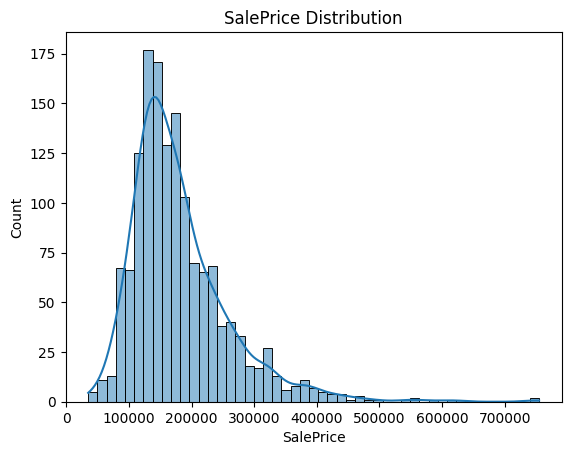

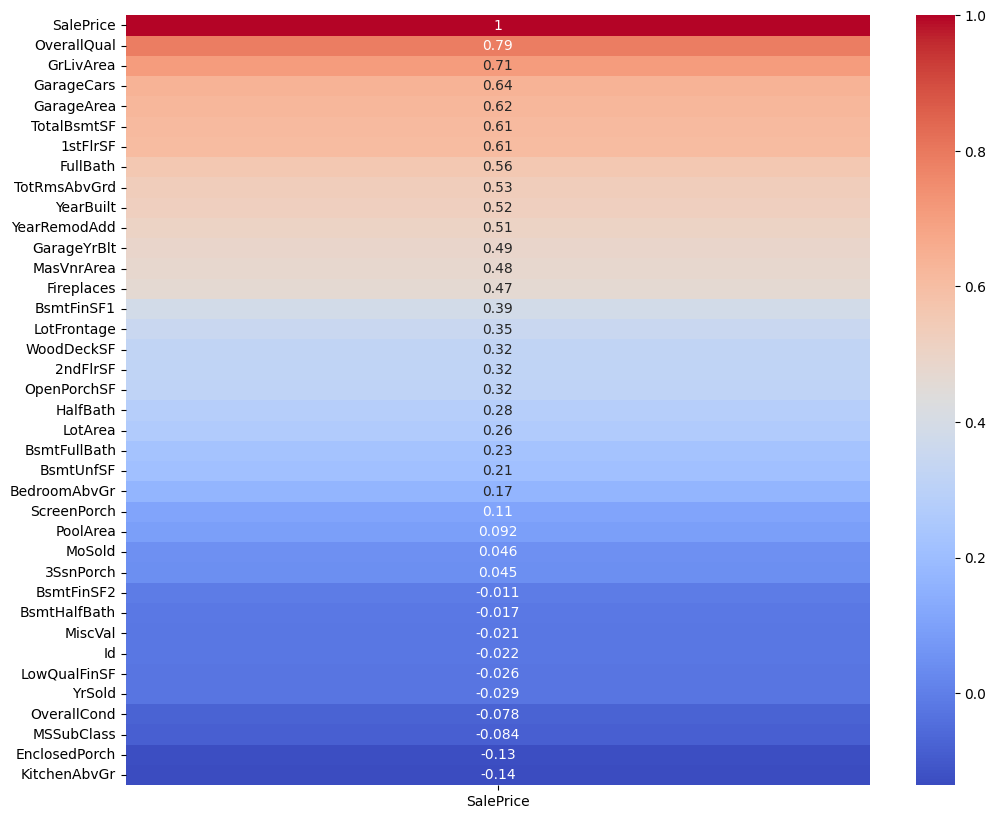

In [3]:
nulls = train.isnull().sum()
nulls[nulls > 0].sort_values(ascending=False)

# Visualize target variable
sns.histplot(train['SalePrice'], kde=True)
plt.title("SalePrice Distribution")

# Correlation heatmap (numeric)
numeric_feats = train.select_dtypes(include=[np.number])
correlation = numeric_feats.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True, cmap='coolwarm')


In [4]:
# Drop columns with too many missing values or low usefulness
train.drop(columns=['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature'], inplace=True)
test.drop(columns=['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature'], inplace=True)

# Separate target
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']

# Identify categorical and numerical features
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Pipelines for preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [5]:
# Create pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
model.fit(X_train, y_train)

# Validate
y_pred = model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print("Validation RMSE:", rmse)


Validation RMSE: 28744.03061428641


In [6]:
# Train on full data
model.fit(X, y)

# Predict
preds = model.predict(test)

# Load sample_submission and create your version
sample = pd.read_csv('../data/sample_submission.csv')
submission = pd.DataFrame({'Id': sample['Id'], 'SalePrice': preds})
submission.to_csv('../submission.csv', index=False)
print("Submission file created.")

Submission file created.


In [8]:
joblib.dump(model, '../models/house_price_model.pkl')
print("Model saved to models/ folder")

Model saved to models/ folder
